In [2]:
import batanalysis as ba
import swiftbat
import swifttools
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import fftpack
from pathlib import Path
from astropy.io import fits
from astropy.stats import sigma_clip
from numpy import mean
from numpy import arange
from scipy.fftpack import fft, rfft
import scipy.fft
from scipy.signal import find_peaks, welch
from scipy.optimize import curve_fit
import datetime
import os

sourcename = "Swift J1727.8-1613"
source = swiftbat.source(sourcename)    # Can look up positions from Simbad, and can calculate exposure for a given pointing
topdir = Path("~/ICR_Project").expanduser()
datafilelistfile = topdir.joinpath("datafiles.txt")


In [3]:
if not datafilelistfile.exists():
    timerange = [swiftbat.string2datetime(t) for t in ("MJD60180", "MJD60186")]
    min_exposure_area = 1000     # cm^2 after cos adjust
    
    table_stoo = swifttools.swift_too.ObsQuery(begin=timerange[0],end=timerange[1])
    download_multi = ba.download_swiftdata(table_stoo, match=['*brtms*'], quiet=True)
    f = datafilelistfile.open("wt")
    for obsid, entry in download_multi.items():
        if not entry['success']:
            continue
        datafile = entry['data'][0].localpath
        print(datafile, file = f)
    f.close()

In [4]:
lcsegments = []
# rate is rate over first 2 energy bins 15-50 keV
slice_ebins=slice(0,2)
timebin = 0.064
skiplength = int(60/timebin)
# Norm is mean-subtracted, stddev-scaled within a pointing
segdtype = np.dtype([('time', np.float64),('rate', np.int16),('norm', np.float32)])

for datafile in datafilelistfile.open().readlines():
    datafile = datafile.strip()
    obsdata = fits.getdata(datafile)
    # Split the data into arrays with no more than a second's gap
    splitlocs = np.argwhere(np.diff(obsdata['time']) > 1.5*timebin).ravel() + 1
    for segmentdata in np.split(obsdata, splitlocs):
        segmentdata = segmentdata[skiplength:]
        if len(segmentdata) == 0:
            continue
        segment = np.empty(len(segmentdata), dtype=segdtype)
        segment['time'] = segmentdata['time']
        rate = np.sum(segmentdata['COUNTS'][:,slice_ebins], axis=1)
        segment['rate'] = rate
        norm = (rate - np.mean(rate))/(0.001 + np.std(rate))
        segment['norm'] = np.clip(norm, -5, 5)
        lcsegments.append(segment)
        # Sort by segment start time
lcsegments = sorted(lcsegments, key = lambda x:x['time'][0])

In [5]:
datafile
len(lcsegments)
len(norm)
len(sigma_clip(norm, sigma=5, maxiters=None, cenfunc=np.mean, masked=False, copy=True))

3163

In [6]:
# Make sure the timebin is right
assert (0.9 * timebin) < np.median(np.diff(lcsegments[0]['time'])) < (1.5 * timebin)

# Use the segments to populate an array
t0 = lcsegments[0]['time'][0]
tmax = lcsegments[-1]['time'][-1]
ntimes = sp.fft.next_fast_len(int((tmax - t0)/timebin  + 10))    # 10 bins of slop, then round up to an FFT-friendly length
lcfull = np.zeros(ntimes)

for segment in lcsegments:
    n = len(segment)
    i0 = int((segment['time'][0] - t0)/timebin)
    lcfull[i0:i0+n] = segment['norm']
    
for datasegment in np.split(obsdata, splitlocs):
    # time of spacecraft, not always accurate because of clock error
    starttime = swiftbat.met2datetime(datasegment['TIME'][0])
    duration = datasegment['TIME'].ptp()
    print(f"{starttime:%Y-%m-%dT%H:%M:%S} + {duration:5.10f} seconds to the end of the block")
    if duration > 1300:
        longdatasegment = datasegment 
print(len(datasegment))

2023-08-29T23:23:39 + 262.3360002041 seconds to the end of the block
4100


In [7]:
# Ignore periods below 10 minutes when looking for peak
def nice_plot(freqs, fpower, ax, **kwargs):   
    grasslevel = np.median(fpower) * 3
    fpower = fpower.copy()
    fpower[(fpower < grasslevel) | (freqs < 1/10)]
    ax.plot(freqs, fpower, **kwargs)
    #ax.set(yscale='log', ylim=[grasslevel, powermax*1.3], xlim=[0,1], ylabel="Power (logscale arbitrary units)")
    ax.set(yscale ='log',  xlim=[0.05,2])
    ax.set_ylim(bottom=grasslevel)

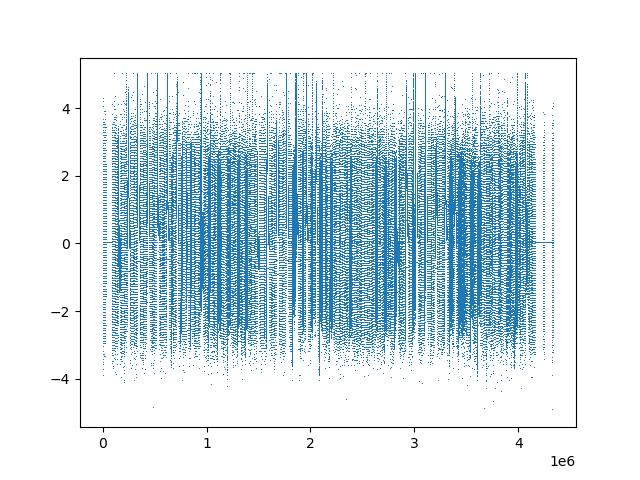

In [8]:
%matplotlib ipympl
fig = plt.figure()
plt.plot(lcfull,',')
plt.show()

In [9]:
# get the highest number of datapoints for FFT

def prev_fast_FFT_len(n):
    ntry = abs(n)
    nfft = sp.fft.next_fast_len(ntry)
    while nfft > n and ntry > 1:
        ntry = int(ntry * 0.99) - 1
        nfft = sp.fft.next_fast_len(ntry)
    return nfft

  0  1824.704 seconds after trimming 2023-08-26 22:28:16.832000
  1  59.072 seconds after trimming 2023-08-27 00:01:04.064000
  2  1834.944 seconds after trimming 2023-08-27 00:03:12.192000
  3  1404.864 seconds after trimming 2023-08-27 00:34:59.072000
  4  217.664 seconds after trimming 2023-08-27 00:59:26.272000
  5  1306.304 seconds after trimming 2023-08-27 01:04:15.232000
  6  596.224 seconds after trimming 2023-08-27 01:27:06.112000
  7  1814.336 seconds after trimming 2023-08-27 01:38:20.800000
  8  1277.696 seconds after trimming 2023-08-27 02:09:43.040000
  9  537.536 seconds after trimming 2023-08-27 02:32:03.200000
 10  1486.784 seconds after trimming 2023-08-27 02:42:13.952000
 11  239.936 seconds after trimming 2023-08-27 03:08:01.600000
 12  89.536 seconds after trimming 2023-08-27 03:13:02.400000
 13  1720.256 seconds after trimming 2023-08-27 03:15:46.880000
 14  511.040 seconds after trimming 2023-08-27 03:45:32.096000
 15  774.080 seconds after trimming 2023-08-27 03

/tmp/ipykernel_173251/1005647247.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/tmp/ipykernel_173251/1005647247.py:9: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.


223  51.776 seconds after trimming 2023-08-29 07:19:30.560000
224  991.168 seconds after trimming 2023-08-29 07:21:30.368000
225  239.936 seconds after trimming 2023-08-29 07:39:04
226  650.432 seconds after trimming 2023-08-29 07:44:10.304000
227  1724.736 seconds after trimming 2023-08-29 07:56:16
228  1486.784 seconds after trimming 2023-08-29 08:26:13.952000
229  239.936 seconds after trimming 2023-08-29 08:52:01.600000
230  1192.512 seconds after trimming 2023-08-29 08:57:08.224000
231  540.608 seconds after trimming 2023-08-29 09:18:03.328000
232  950.336 seconds after trimming 2023-08-29 09:28:12.800000
233  1486.784 seconds after trimming 2023-08-29 09:45:16.352000
234  950.336 seconds after trimming 2023-08-29 10:11:12
235  532.160 seconds after trimming 2023-08-29 10:28:06.976000
236  1013.696 seconds after trimming 2023-08-29 10:38:07.040000
237  540.608 seconds after trimming 2023-08-29 10:56:03.328000
238  653.120 seconds after trimming 2023-08-29 11:06:09.216000
239  1672

IndexError: list index out of range

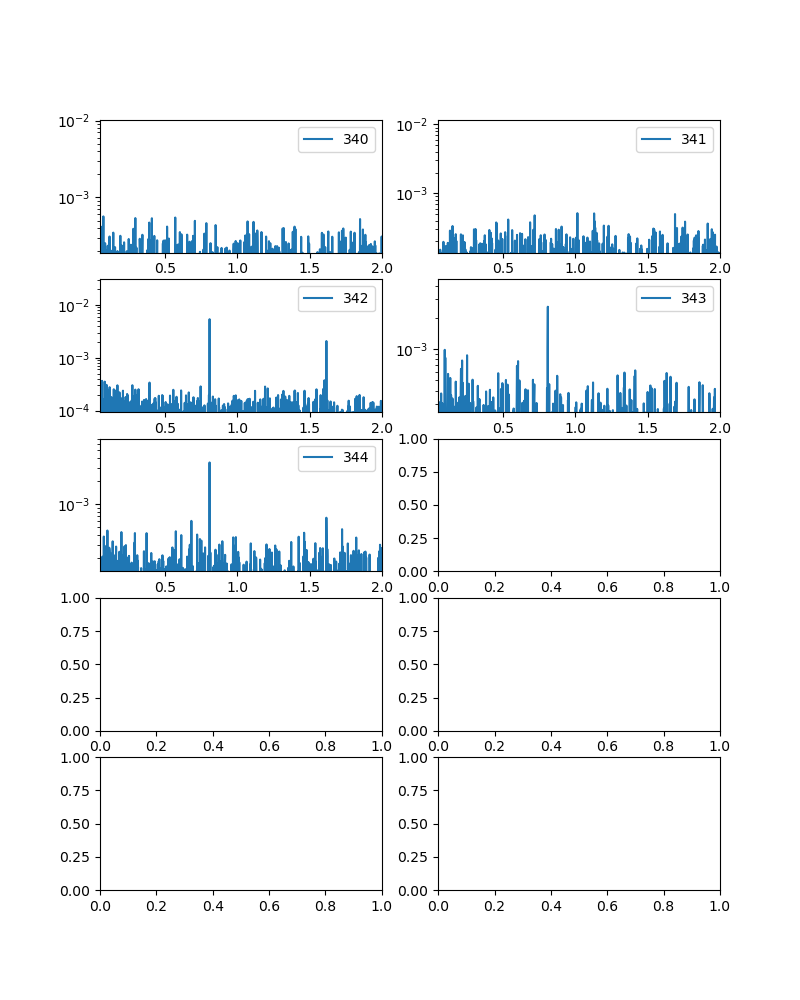

In [9]:
# refind the amount of datapoints afte cutting off the first minute (BAT is still adjusting the first min)
for istart in range(0,len(lcsegments), 10):

    plt.close('all')
    fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (8, 10))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
    for di, ax in enumerate(np.ravel(axes)):
        i = istart + di
        datasegment = lcsegments[i]
        n = prev_fast_FFT_len(len(datasegment))
        # Trim to the last n valuesfits.getdata(filename,  header=True)
        datasegment = datasegment[-n:]
        duration = datasegment['time'].ptp()
        filtered_data = datasegment['norm']
        ntimes = len(filtered_data)
        # Do the Fourier transform, and get the corresponding frequencies and powers
        fnorm = sp.fft.rfft(filtered_data, norm='forward')
        freqs = abs(sp.fft.rfftfreq(ntimes, timebin))
        fpower = np.abs(fnorm)**2
        nice_plot(freqs, fpower, ax, label = f'{i}')
        print(f"{i:3d}  {duration:.3f} seconds after trimming", 
              swiftbat.met2datetime(datasegment['time'][0]))
        ax.legend()
        fig.savefig(f"/tmp/powerbyseg{istart:03d}.pdf")
    #plt.show()

In [10]:
QPO_segments = [36,42, 49, 64, 72, 73, 78, 79, 85, 86, 90, 117, 122, 128, 134, 141, 142]

ValueError: Axis limits cannot be NaN or Inf

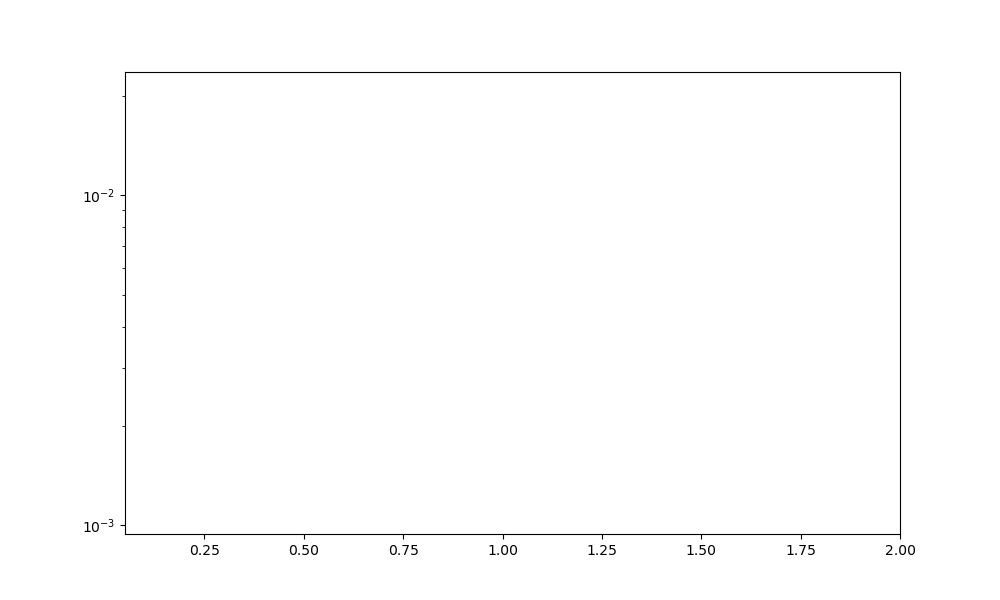

In [11]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10, 6))

clip_level = 1e-3
# Iterate through segments and plot each power spectrum on the same axes
for i, datasegment in enumerate(lcsegments):
    n = prev_fast_FFT_len(len(datasegment))
    datasegment = datasegment[-n:]
    filtered_data = datasegment['norm']
    ntimes = len(filtered_data)
    fnorm = sp.fft.rfft(filtered_data, norm='forward')
    fpower = np.abs(fnorm)**2
    freqs = sp.fft.rfftfreq(ntimes, timebin)
    fpower[fpower < clip_level] = np.nan
    # Call nice_plot function to plot the current segment
    nice_plot(freqs, fpower, ax)
    print(swiftbat.met2datetime(datasegment['time'][0]))

# Set log scale, limits, labels, title, legend, and grid
#ax.set_yscale('log')
#ax.set_ylim(bottom=0, top=None)  
#ax.set_xlim(left=0.05, right=2)  
ax.set_xlabel('Frequency')
ax.set_ylabel('Power') 
ax.set_title('Overlay of Power Spectra from Segments')
ax.grid(True)

# Show the plot
plt.show()

In [ ]:
datasegment
i
len(lcsegments[i])
swiftbat.met2datetime(datasegment['time'][0])

In [ ]:
plt.close('all')
plt.figure()
plt.plot(freqs, fpower)
plt.show()

freqmax = 0.02575669893378227 Hz, powermax = nan, grasslevel = nan


ValueError: Axis limits cannot be NaN or Inf

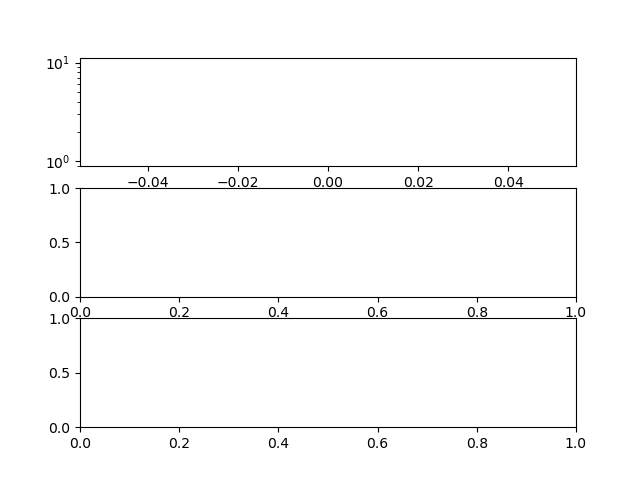

In [12]:

# Ignore periods below 10 minutes when looking for peak
zerof_ignore = int(ntimes/(600))
imax = zerof_ignore + np.argmax(fpower[zerof_ignore:])
freqmax = freqs[imax]
powermax = fpower[imax]
# Don't plot all points because that takes a long time
grasslevel = np.median(fpower) * 10
wplot = np.argwhere(fpower > grasslevel).ravel()

# Ignore periods below 20 minutes when looking for peak
zerof_ignore_2 = int(ntimes/(60))
imax_2 = zerof_ignore_2 + np.argmax(fpower[zerof_ignore_2:])
freqmax_2 = freqs[imax_2]
powermax_2 = fpower[imax_2]
# Don't plot all points because that takes a long time
grasslevel_2 = np.median(fpower) * 10
wplot_2 = np.argwhere(fpower > grasslevel_2).ravel()

print(f"{freqmax = } Hz, {powermax = }, {grasslevel = }")


fig, axes = plt.subplots(nrows=3, ncols=1)
axes[0].plot(freqs[wplot], fpower[wplot])
axes[0].set(yscale='log', ylim=[grasslevel, powermax*1.3], xlim=[0,1], ylabel="Power (logscale arbitrary units)")
for harmonic in range(1,5):
    irange = ((imax + np.asarray([-200,201])) * harmonic).astype(int)
    axes[1].plot(freqs[irange[0]:irange[1]]/harmonic, fpower[irange[0]:irange[1]], label=f"n={harmonic}")
axes[1].legend() #
axes[1].set(title=f"harmonic of {freqmax:f} Hz", xlabel="Frequency and harmonic-adjusted frequency (Hz)")
fig.tight_layout()

for harmonic in range(1,5):
    irange_2 = ((imax_2 + np.asarray([-200,201])) * harmonic).astype(int)
    axes[2].plot(freqs[irange_2[0]:irange_2[1]]/harmonic, fpower[irange_2[0]:irange_2[1]], label=f"n={harmonic}")
axes[2].legend() #
axes[2].set(title=f"harmonic of {freqmax_2:f} Hz", xlabel="Frequency and harmonic-adjusted frequency (Hz)")
fig.tight_layout()
plt.show()

In [ ]:
obsdata
lcsegments[0]
datasegment.dtype

(28512,)
(28512,)
Length of datasegment: 28512
time:  715044280.8960001
200.640 seconds after trimming
3136


ValueError: x and y must have same first dimension, but have shapes (3136,) and (3500,)

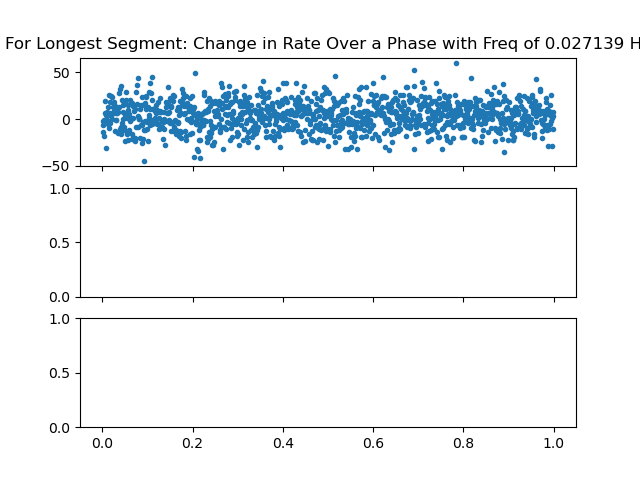

In [13]:
tzero = swiftbat.string2met('2023-08-27T00:00:00')
fapprox = .027139
cycle, phase = np.divmod((datasegment['time'] - tzero) * fapprox, 1)
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)

print(filtered_data.shape)
print(datasegment['time'].shape)

# plotting just the 1300s segment
#rate = np.sum(datasegment['COUNTS'][0:2]) / timebin
#print(len(datasegment))

segpieces = 4
# Break the segment into 4 pieces
pointsperplot = 2 * int(1 / (0.064 * fapprox))

print(f"Length of datasegment: {len(datasegment)}")

# For each segment, plot 2 cycles of data
for istart in np.arange(0, len(datasegment), 1 + len(datasegment) // segpieces):
    sl = slice(istart, istart + pointsperplot)
    time_values = datasegment['time']
if isinstance(time_values, np.ndarray):
    phase_values = phase[sl]
    rate_values = filtered_data[sl] / timebin
    axes[0].plot(phase_values, rate_values, ".", label=f"{time_values[0] - tzero:.0f}") 
else:
    print("Warning: time_values is not an array")   
axes[0].set_title(f"For Longest Segment: Change in Rate Over a Phase with Freq of {fapprox} Hz")

# 1 cycle of data for all 11 data segments
for datasegment in np.split(obsdata, splitlocs):
    n = prev_fast_FFT_len(len(datasegment) - int(60 / timebin))
    datasegment = datasegment[-n:]
    duration = datasegment['time'].ptp()
    print("time: ", datasegment['time'][0])
    print(f"{duration:.3f} seconds after trimming")
    segrate = filtered_data / timebin
    segcycle, segphase = np.divmod((datasegment['time'] - tzero) * fapprox, 1)
    print(len(datasegment))
    axes[1].plot(segphase[:3500], segrate[:3500], ".", label="Segmentation")
    
axes[1].legend()
axes[1].set_title(f"For All segments: Change in Rate Over a Phase with Freq of {fapprox} Hz")

fapprox = .641961

for datasegment in np.split(obsdata, splitlocs):
    n = prev_fast_FFT_len(len(datasegment) - int(60 / timebin))
    datasegment = datasegment[-n:]
    duration = datasegment['time'].ptp()
    print("time: ", datasegment['time'][0])
    print(f"{duration:.3f} seconds after trimming")
    segrate = filtered_data/ timebin
    segcycle, segphase = np.divmod((datasegment['time'] - tzero) * fapprox, 1)
    print(len(datasegment))
    axes[2].plot(segphase[:3500], segrate[:3500], ".", label="Segmentation")
    
axes[2].legend()
axes[2].set_title(f"For All segments: Change in Rate Over a Phase with Freq of {fapprox} Hz")
plt.show()

In [ ]:

# Define tzero (assuming swiftbat.string2met is defined elsewhere)
tzero = swiftbat.string2met('2023-08-27T05:22:01')

# Assuming datasegment is your data containing 'TIME' and 'COUNTS' fields
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), sharex=True)

# Number of segments to split the data into
segpieces = 4

# List to store FFT results
stacked_freq_values = []
stacked_counts_fft = []

# Plotting frequency spectrum for each segment
for i, istart in enumerate(np.arange(0, len(datasegment), len(datasegment) // segpieces)):
    sl = slice(istart, istart + len(datasegment) // segpieces)
    time_values = datasegment['time'][sl]
    counts_data = datasegment['COUNTS'][sl]

    # Perform FFT on COUNTS data
    counts_fft = scipy.fft.rfft(counts_data)
    freq_values = scipy.fft.rfftfreq(len(counts_data), d=(time_values[-1] - time_values[0]) / len(counts_data))

    # Rescale to the same frequency range
    max_freq = np.max(freq_values)
    freq_interp = np.linspace(0, max_freq, len(freq_values))

    # Ensure counts_fft is 1D
    counts_fft_abs = np.abs(counts_fft)
    if counts_fft_abs.ndim > 1:
        counts_fft_abs = counts_fft_abs.flatten()

    # Print shapes for debugging
    print(f"freq_interp shape: {freq_interp.shape}")
    print(f"freq_values shape: {freq_values.shape}")
    print(f"counts_fft_abs shape: {counts_fft_abs.shape}")

    # Ensure lengths match before interpolation
    min_len = min(len(freq_values), len(counts_fft_abs))
    freq_values = freq_values[:min_len]
    counts_fft_abs = counts_fft_abs[:min_len]

    # Interpolating and stacking FFT results
    counts_fft_rescaled = np.interp(freq_interp, freq_values, counts_fft_abs)

    # Plot the frequency spectrum for the current segment
    axes[0].plot(freq_values, counts_fft_abs, label=f"Segment {i}")

    # Stack FFT results
    stacked_freq_values.append(freq_interp)  # Use freq_interp to ensure consistent frequency range
    stacked_counts_fft.append(counts_fft_rescaled)
    break

axes[0].legend()
axes[0].set_title("Frequency Spectrum for Segments")

# Stacking FFT results
stacked_freq_values = np.concatenate(stacked_freq_values)
stacked_counts_fft = np.array(stacked_counts_fft)

# Plot stacked and rescaled frequency spectrum
axes[1].imshow(stacked_counts_fft, aspect='auto', origin='lower', extent=[np.min(stacked_freq_values), np.max(stacked_freq_values),0, segpieces])
axes[1].set_title("Stacked and Rescaled Frequency Spectrum")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Segment")
axes[1].invert_yaxis()

plt.show()


KeyError: "Key 'RATE' does not exist."

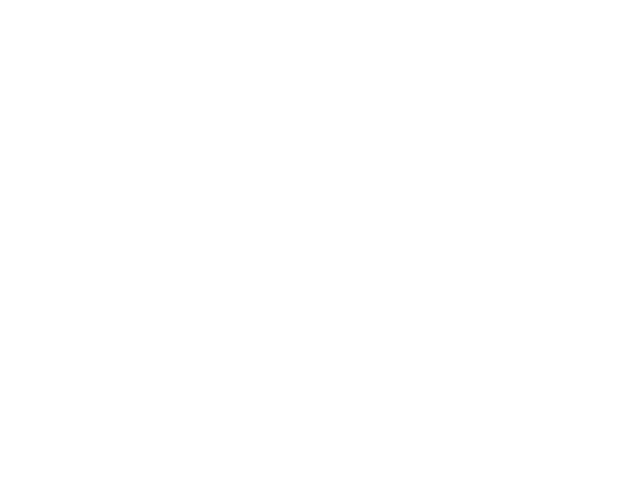

In [14]:
len(datasegment)
datasegment.dtype
plt.close('all')
plt.figure()
plt.plot(datasegment['TIME'], datasegment['RATE'])

Looking for files in: /home/camila/Downloads
Files found: [PosixPath('/home/camila/Downloads/SWIFTJ1727.8-1613.lc.fits')]


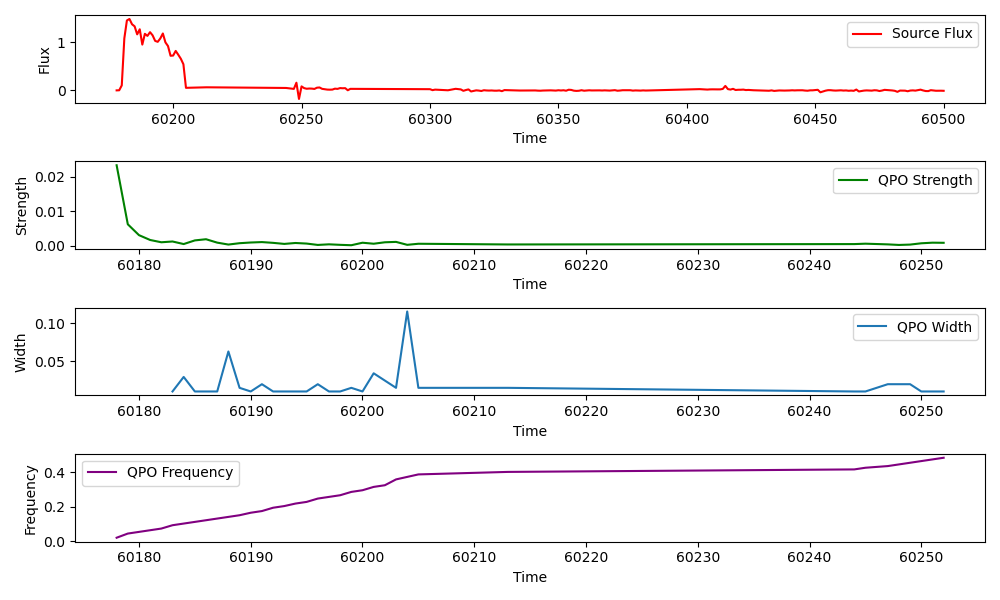

In [15]:
# Load the data
swiftflux = "SWIFTJ1727.8-1613.lc.fits"  # time
pathname = Path("~/Downloads").expanduser()

# Check if the path is correct
print(f"Looking for files in: {pathname}")

swiftfilename = list(pathname.rglob(swiftflux))

# Check if any files were found
if not swiftfilename:
    print(f"No files found matching: {swiftflux} in {pathname}")
else:
    print(f"Files found: {swiftfilename}")

# Assuming only one file is found
sdata, sheader = fits.getdata(swiftfilename[0], header=True)

# tzero = swiftbat.met2mjd(swiftbat.string2met('2023-08-27T00:00:00'))
# print(tzero)

sdataflux = sdata['RATE']
sdatatime = sdata['TIME']

# If datasegment is not defined, assume the entire data segment
datasegment = sdata  # Using entire data as segment
timebin = 1  # Define the time bin, for example purposes set to 1

time_values = datasegment['TIME']
rate_values = datasegment['RATE']  

# Preprocess the data
# Detrending 
# flux_detrended = sdataflux - np.mean(sdataflux)

# Identify QPO peaks using Welch's method for PSD
fs = 1 / (time_values[1] - time_values[0])  # Sampling frequency
frequencies, power_spectrum = welch(rate_values, fs=fs, nperseg=min(256, len(rate_values)))

# Find peaks in the power spectrum
peaks, _ = find_peaks(power_spectrum, height=0)

# Extract QPO parameters
qpo_frequencies = frequencies[peaks]
qpo_strengths = power_spectrum[peaks]
qpo_widths = []  # Placeholder for peak widths calculation

# Calculate widths (FWHM) - simple approximation
for peak in peaks:
    half_max = power_spectrum[peak] / 2
    left_idx = np.where(power_spectrum[:peak] <= half_max)[0]
    right_idx = np.where(power_spectrum[peak:] <= half_max)[0]
    
    if len(left_idx) > 0 and len(right_idx) > 0:
        width = frequencies[right_idx[0] + peak] - frequencies[left_idx[-1]]
        qpo_widths.append(width)
    else:
        qpo_widths.append(np.nan)

# Plot QPO parameters against time
plt.figure(figsize=(10, 6))

plt.subplot(4, 1, 1)
plt.plot(sdatatime, sdataflux, color = 'r', label='Source Flux')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(time_values[:len(qpo_strengths)], qpo_strengths, color = 'g', label='QPO Strength')
plt.xlabel('Time')
plt.ylabel('Strength')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(time_values[:len(qpo_widths)], qpo_widths, label='QPO Width')
plt.xlabel('Time')
plt.ylabel('Width')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(time_values[:len(qpo_frequencies)], qpo_frequencies, color = 'purple', label='QPO Frequency')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()
